# EoR Signal Separation with a CDAE

---

### Weitian LI

https://github.com/liweitianux/cdae-eor

**Credits:**
* https://ramhiser.com/post/2018-05-14-autoencoders-with-keras/
* https://blog.keras.io/building-autoencoders-in-keras.html

---

## Introduction

The **frequency-dependent beam effects** of interferometers can cause
rapid fluctuations along the frequency dimension, which destroy the
smoothness of the foreground spectra and prevent traditional foreground
removal methods from uncovering the EoR signal.

Given the difficulty in crafting practicable models to overcome the
complicated beam effects, methods that can learn tailored models from
the data seem more feasible and appealing.

**Convolutional denoising autoencoder** (CDAE) combines the strengths of
both denoising autoencoder and convolutional neural network and hence
is very powerful to learn robust and sophiscated features from the data.
The CDAE is well suited to learn the subtle features of the faint EoR
signal and separate it from the strong foreground emission, even in the
presence of serious beam effects.

---

## 1. Import packages and basic settings

In [1]:
import os
from os import path
from datetime import datetime

import numpy as np
from astropy.io import fits

from scipy import signal
from scipy import fftpack

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
mpl.style.use("ggplot")
for k, v in [("font.family",       "Inconsolata"),
             ("font.size",         14.0),
             ("pdf.fonttype",      42),  # Type 42 (a.k.a. TrueType)
             ("figure.figsize",    [8, 6]),
             ("image.cmap",        "jet"),
             ("xtick.labelsize",   "large"),
             ("xtick.major.size",  7.0),
             ("xtick.major.width", 2.0),
             ("xtick.minor.size",  4.0),
             ("xtick.minor.width", 1.5),
             ("ytick.labelsize",   "large"),
             ("ytick.major.size",  7.0),
             ("ytick.major.width", 2.0),
             ("ytick.minor.size",  4.0),
             ("ytick.minor.width", 1.5)]:
    mpl.rcParams[k] = v

In [26]:
import tensorflow as tf

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D
from keras.optimizers import Adam

keras.__version__, tf.__version__

Using TensorFlow backend.


('2.2.4', '1.12.0')

In [27]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

---

## 2. Custom functions

In [12]:
def rms(a, axis=None):
    return np.sqrt(np.mean(a**2, axis=axis))

In [13]:
def a_summary(a):
    print('min:', np.min(a))
    print('max:', np.max(a))
    print('mean:', np.mean(a))
    print('std:', np.std(a))
    print('median:', np.median(a))

In [6]:
def calc_rfft(cube):
    cube = np.array(cube)
    nfreq, ny, nx = cube.shape
    data = cube.reshape((nfreq, ny*nx))
    data = np.swapaxes(data, 0, 1)  # [npix, nfreq]
    
    window = signal.nuttall(nfreq, sym=False)
    data *= window[np.newaxis, :]
    
    return np.fft.rfft(data, axis=1)

In [7]:
# Parameters:
#   - s: rfft result of 1D signal
#   - nex: number of lowest frequency points to be excluded

def rfft_encode1(s, nex=0):
    s = s[nex:]
    return np.concatenate([np.real(s), np.imag(s)[::-1]])


def rfft_decode1(s, nex=0):
    m = len(s) // 2
    real = s[:m]
    imag = s[:(m-1):-1]
    x = real + imag*1j
    return np.concatenate([np.zeros((nex,)), x])

In [8]:
# Parameters:
#   - s: rfft result [npix, nfreq]
#   - nex: number of lowest frequency points to be excluded

def rfft_encode2(s, nex=0):
    s = s[:, nex:]
    return np.column_stack([np.real(s), np.imag(np.fliplr(s))])


def rfft_decode2(s, nex=0):
    npix, nfreq = s.shape
    m = nfreq // 2
    real = s[:, :m]
    imag = np.fliplr(s[:, m:])
    x = real + imag*1j
    return np.column_stack([np.zeros((npix, nex)), x])

In [9]:
# correlation coefficient

def corrcoef(s1, s2):
    # calculate: np.corrcoef(s1, s2)[0, 1]
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    return np.sum((s1-m1) * (s2-m2)) / np.sqrt(np.sum((s1-m1)**2) * np.sum((s2-m2)**2))


def corrcoef_ds(ds1, ds2):
    # shape: [npix, nfreq]
    n = ds1.shape[0]
    cc = np.zeros((n,))
    for i in range(n):
        cc[i] = corrcoef(ds1[i, :], ds2[i, :])
    return cc


def corrcoef_freqpix(fparray1, fparray2):
    # shape: [nfreq, npix]
    __, npix = fparray1.shape
    cc = np.zeros((npix,))
    for i in range(npix):
        cc[i] = corrcoef(fparray1[:, i], fparray2[:, i])
    return cc

In [21]:
def normalize_ds(zen_tot, zen_eor, zen_fg, q=(1, 99)):
    x_mean, x_std = np.mean(zen_tot), np.std(zen_tot)
    x_data = (zen_tot - x_mean) / x_std
    
    x_fg = (zen_fg - x_mean) / x_std

    vlow, vhigh = np.percentile(zen_eor, q=q)
    x_label = np.array(zen_eor)
    x_label[x_label < vlow]  = vlow
    x_label[x_label > vhigh] = vhigh
    x_label /= max(abs(vlow), abs(vhigh))
    
    return (x_data, x_label, x_fg)

In [14]:
# Re-initialize weights
# credit: https://www.codementor.io/nitinsurya/how-to-re-initialize-keras-model-weights-et41zre2g

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [16]:
# Credit: https://keunwoochoi.wordpress.com/2016/07/16/keras-callbacks/

class EvalIndexCallback(keras.callbacks.Callback):
    """
    Calculate the evaluation index on the validation set
    at the end of epoches.
    """
    def __init__(self, func, loss_func=None, train_data=None, test_data=None):
        super().__init__()
        self.func = func
        self.loss_func = loss_func
        self.train_data = train_data
        self.metrics = ['mean', 'std', 'median']
        
        self.val_results = {'epoch': []}
        for n in self.metrics:
            self.val_results[n] = []
            
        self.test_data = test_data
        if test_data:
            self.test_results = {'epoch': []}
            for n in self.metrics:
                self.test_results[n] = []
        
        if loss_func:
            self.train_loss = {'epoch': [], 'mean': [], 'std': []}
            self.val_loss = {'epoch': [], 'mean': [], 'std': []}
    
    def _predict(self):
        data = self.validation_data[0]
        self._x_validation_pred = self.model.predict(data)
        if self.test_data:
            data = self.test_data[0]
            self._x_test_pred = self.model.predict(data)
        if self.loss_func:
            data = self.train_data[0]
            self._x_train_pred = self.model.predict(data)
            
    def _calc_loss(self, epoch):
        if self.loss_func is None:
            return
        
        pred = self._x_train_pred
        label = self.train_data[1]
        res = self.train_loss
        m, s = self.loss_func(pred, label)
        res['epoch'].append(epoch)
        res['mean'].append(m)
        res['std'].append(s)
        print(f'    loss[train]: {m:.4f} +/- {s:.4f}')
        
        pred = self._x_validation_pred
        label = self.validation_data[1]
        res = self.val_loss
        m, s = self.loss_func(pred, label)
        res['epoch'].append(epoch)
        res['mean'].append(m)
        res['std'].append(s)
        print(f'    loss[validation]: {m:.4f} +/- {s:.4f}')
        
    def _calc_results(self, epoch, type_):
        if type_ == 'validation':
            res = self.val_results
            data, label = self.validation_data[:2]
            pred = self._x_validation_pred
        else:
            res = self.test_results
            data, label = self.test_data
            pred = self._x_test_pred
            
        res['epoch'].append(epoch)
        n = data.shape[0]
        m = np.zeros((n,))
        for i in range(n):
            m[i] = self.func(pred[i, :, 0], label[i, :, 0])
        for n in self.metrics:
            res[n].append(getattr(np, n)(m))
                
    def on_epoch_end(self, epoch, logs=None):
        # 'epoch' starts from 0
        self._predict()
        self._calc_loss(epoch)
        
        self._calc_results(epoch, type_='validation')
        m = self.val_results['mean'][-1]
        s = self.val_results['std'][-1]
        print(f'    index[validation]: {m:.4f} +/- {s:.4f}')
        
        if self.test_data:
            self._calc_results(epoch, type_='test')
            m = self.test_results['mean'][-1]
            s = self.test_results['std'][-1]
            print(f'    index[test]: {m:.4f} +/- {s:.4f}')

In [17]:
def plot_modelfit(model, callback, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)

    res = callback.val_results
    x = np.array(res['epoch']) + 1
    y = np.array(res['mean'])
    yerr = np.array(res['std'])
    ax.plot(x, y, color='C5', lw=2.5, label='Correlation coef.')
    ax.fill_between(x, y-yerr, y+yerr, color='C5', alpha=0.4)
    ax.set(xlabel='Epoch', ylabel='Correlation coefficient')

    history = model.history.history
    n_epoch = len(history['loss'])
    epoch = np.arange(n_epoch) + 1
    loss = np.array(history['loss'])
    val_loss = np.concatenate([[np.nan], np.array(history['val_loss'])[:-1]])
    ax_ = ax.twinx()
    ax_.plot(epoch, loss, color='C0', lw=2.5, alpha=0.8, label='Training loss')
    ax_.plot(epoch, val_loss, color='C1', lw=2.5, alpha=0.8, label='Validation loss')
    ax_.set(ylabel='MSE Loss')
    ax_.grid(False)
    
    h1, l1 = ax_.get_legend_handles_labels()
    h2, l2 = ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc='center right')
    
    for l in ax.lines+ax_.lines:
        l.set_zorder(3)

    plt.tight_layout()
    plt.show()
    return fig, (ax, ax_)

In [18]:
def plot_modelresult(idx, xinput, xlabel, xpred, figsize=(8, 8)):
    tinput = xinput[idx, :, 0]
    tlabel = xlabel[idx, :, 0]
    tpred  = xpred[ idx, :, 0]

    tinput2 = rfft_decode1(tinput, nex=nex)
    tlabel2 = rfft_decode1(tlabel, nex=nex)
    tpred2  = rfft_decode1(tpred,  nex=nex)
    sinput = np.fft.irfft(tinput2, n=nfreq0)
    slabel = np.fft.irfft(tlabel2, n=nfreq0)
    spred  = np.fft.irfft(tpred2,  n=nfreq0)
    
    nf0 = len(slabel)
    tx0 = np.linspace(154, 162, nf0)
    tx  = np.arange(nf0) - (nf0 // 2)

    tinput3 = np.concatenate([np.imag(tinput2)[::-1], np.real(tinput2)[1:]])
    tlabel3 = np.concatenate([np.imag(tlabel2)[::-1], np.real(tlabel2)[1:]])
    tpred3  = np.concatenate([np.imag(tpred2 )[::-1], np.real(tpred2 )[1:]])
    
    print(f'corrcoef(tpred, tlabel): {corrcoef(tpred, tlabel)}')
    print(f'corrcoef(spred, slabel): {corrcoef(spred, slabel)}')
    
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=figsize)

    ax0.plot(tx, tinput3, color='C3', alpha=0.4, label='EoR+FG')
    ax0.plot(tx, tlabel3, color='C5', alpha=0.8, lw=2.5, label="input EoR")
    ax0.plot(tx, tpred3,  color='C1', alpha=0.8, lw=2.5, ls='--', label='reconstructed EoR')
    ax0.axvspan(-(nex-1), (nex-1), fill=False, edgecolor="magenta", hatch="/", alpha=0.5)
    ax0.legend()
    ax0.set(xlim=(-nf0//2-1, nf0//2+1),
            ylim=(-1.3, 1.3),
            xlabel='Fourier frequency',
            ylabel='Fourier coefficient')

    ax1.plot(tx0, slabel, color='C5', alpha=0.8, lw=2.5, label="input EoR")
    ax1.plot(tx0, spred,  color='C1', alpha=0.8, lw=2.5, ls='--', label='reconstructed EoR')
    ax1.legend()
    ax1.set(xlabel='Frequency [MHz]',
            ylabel='Brightness temperature')

    plt.tight_layout()
    plt.show()
    return fig, (ax0, ax1)

---

## 3. Load data

In [10]:
# datadir = '../data'

datadir = path.expanduser('~/works/eor-detection/oskar')
# training & valiation data
cube_eor = fits.open(path.join(datadir, 'eor.uvcut_b158c80_n360-cube.fits'))[0].data
cube_fg  = fits.open(path.join(datadir, 'fg.uvcut_b158c80_n360-cube.fits' ))[0].data
# testing data
cube_eor2 = fits.open(path.join(datadir, 'eor.uvcut.sft_b158c80_n360-cube.fits'))[0].data
cube_fg2  = fits.open(path.join(datadir, 'fg.uvcut.sft_b158c80_n360-cube.fits' ))[0].data

# without instrument observation
datadir = path.join(datadir, '../skymap')
skycube_eor = fits.open(path.join(datadir, 'eor_b158c80_n360-cube.fits'))[0].data
skycube_fg  = fits.open(path.join(datadir, 'fg_b158c80_n360-cube.fits' ))[0].data

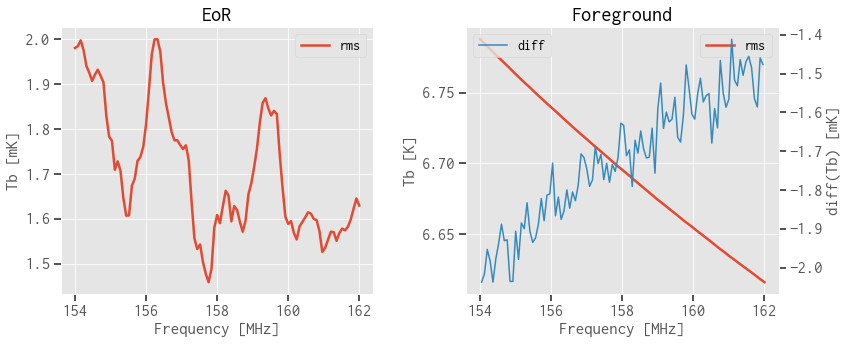

In [14]:
def plot_cubes(cube_eor, cube_fg):
    nfreq = cube_eor.shape[0]
    freqs = np.linspace(154, 162, nfreq)
    fmid = (freqs[1:] + freqs[:-1]) / 2
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

    ax = ax0
    eor_rms = rms(cube_eor, axis=(1,2)) * 1e3  # mK
    ax.plot(freqs, eor_rms, lw=2.5, label='rms')
    ax.legend()
    ax.set(xlabel='Frequency [MHz]', ylabel='Tb [mK]', title='EoR')

    ax = ax1
    fg_rms = rms(cube_fg, axis=(1,2))
    ax.plot(freqs, fg_rms, lw=2.5, label='rms')
    ax.legend()
    ax.set(xlabel='Frequency [MHz]', ylabel='Tb [K]', title='Foreground')
    ax_ = ax.twinx()
    ax_.plot(fmid, np.diff(fg_rms)*1e3, color='C1', label='diff')
    ax_.legend()
    ax_.set(ylabel='diff(Tb) [mK]')
    ax_.grid(False)

    fig.tight_layout()
    plt.show()
    
    
plot_cubes(cube_eor, cube_fg)

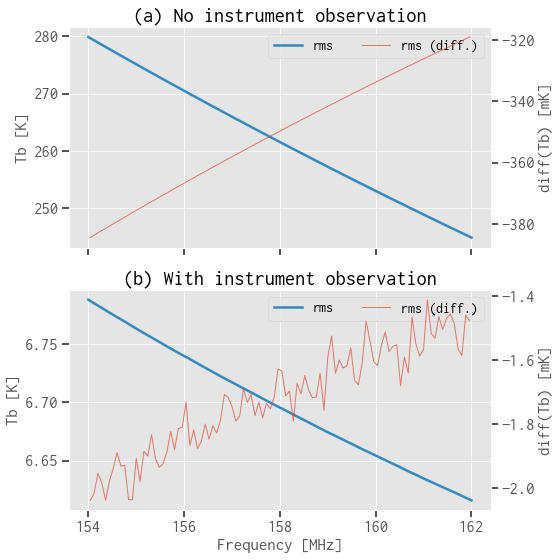

figure saved to file: /home/aly/git/cdae-eor/code/simudata.pdf


In [17]:
def plot_simudata(cube, skycube, figsize=(8, 12)):
    nf, ny, nx = cube.shape
    f = np.linspace(154, 162, nf)
    f2 = (f[1:] + f[:-1]) / 2

    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=figsize, sharex=True)

    xlabel = 'Frequency [MHz]'
    ylabel = 'Tb [K]'
    ylabel2 = 'diff(Tb) [mK]'
    ax0.set(ylabel=ylabel,
            title='(a) No instrument observation')
    ax0_ = ax0.twinx()
    ax0_.set_ylabel(ylabel2)
    ax0_.grid(False)
    
    ax1.set(xlabel=xlabel, ylabel=ylabel,
            title='(b) With instrument observation')
    ax1_ = ax1.twinx()
    ax1_.set_ylabel(ylabel2)
    ax1_.grid(False)
    
    y = rms(skycube, axis=(1,2))
    ax0.plot(f, y, color='C1', lw=2.5, label='rms')
    y2 = np.diff(y) * 1e3  # [mK]
    ax0_.plot(f2, y2, color='C0', lw=1, alpha=0.7, label='rms (diff.)')
    
    y = rms(cube, axis=(1,2))
    y = np.abs(y)
    ax1.plot(f, y, color='C1', lw=2.5, label='rms')
    y2 = np.diff(y) * 1e3  # [mK]
    ax1_.plot(f2, y2, color='C0', lw=1, alpha=0.7, label='rms (diff.)')
    
    h1, l1 = ax0.get_legend_handles_labels()
    h2, l2 = ax0_.get_legend_handles_labels()
    ax0.legend(h1+h2, l1+l2, ncol=2, loc='upper right')
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax1_.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, ncol=2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    return fig, (ax0, ax1)


fig, axes = plot_simudata(cube_fg, skycube_fg, figsize=(8, 8))
if False:
    fn = 'simudata.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

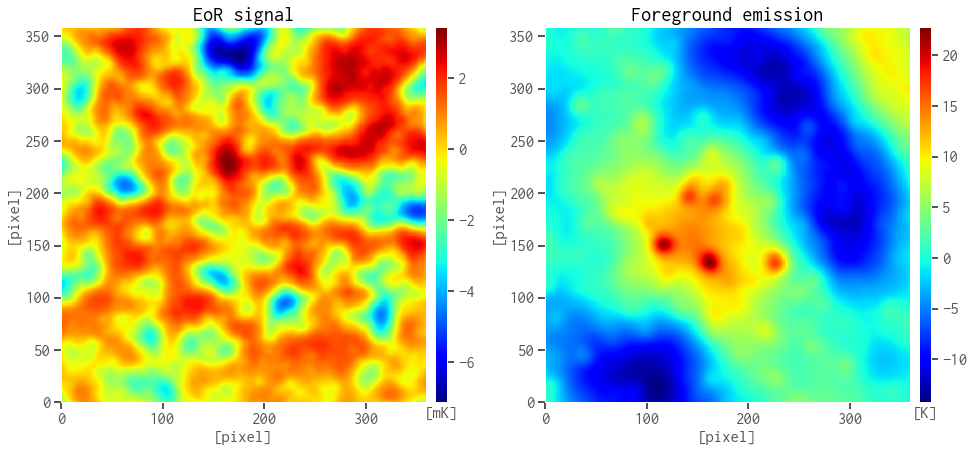

image saved to: /home/aly/git/cdae-eor/code/obsimg-158.png


In [16]:
def plot_slice(cube_eor, cube_fg, i=50, figsize=(14, 6.5)):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=figsize)

    ax = ax0
    slc_eor = cube_eor[i, :, :]
    nx, ny = slc_eor.shape
    mappable = ax.pcolormesh(np.arange(nx), np.arange(ny), slc_eor*1e3, cmap='jet')
    vmin, vmax = mappable.get_clim()
    cb = ax.figure.colorbar(mappable, ax=ax, pad=0.02, aspect=30)
    cb.ax.set_xlabel('[mK]')
    ax.set(title='EoR signal', xlabel='[pixel]', ylabel='[pixel]')

    ax = ax1
    slc_fg = cube_fg[i, :, :]
    nx, ny = slc_fg.shape
    mappable = ax.pcolormesh(np.arange(nx), np.arange(ny), slc_fg, cmap='jet')
    vmin, vmax = mappable.get_clim()
    cb = ax.figure.colorbar(mappable, ax=ax, pad=0.02, aspect=30)
    cb.ax.set_xlabel('[K]')
    ax.set(title='Foreground emission', xlabel='[pixel]', ylabel='[pixel]')

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1)
    plt.show()
    return (fig, (ax0, ax1))


fig, axes = plot_slice(cube_eor, cube_fg)
if False:
    fn = 'obsimg-158.png'
    fig.savefig(fn, dpi=120)
    print(f'image saved to: {path.abspath(fn)}')

---

## 4. Preprocessing

In [18]:
cube_tot  = cube_fg  + cube_eor
cube_tot2 = cube_fg2 + cube_eor2

In [19]:
z_eor  = calc_rfft(cube_eor)
z_tot  = calc_rfft(cube_tot)
z_fg   = calc_rfft(cube_fg)

z_eor2 = calc_rfft(cube_eor2)
z_tot2 = calc_rfft(cube_tot2)
z_fg2  = calc_rfft(cube_fg2)

In [20]:
# number of lowest Fourier coefficients to be excised
nex = 6

zen_eor  = rfft_encode2(z_eor, nex=nex)
zen_tot  = rfft_encode2(z_tot, nex=nex)
zen_fg   = rfft_encode2(z_fg,  nex=nex)

zen_eor2 = rfft_encode2(z_eor2, nex=nex)
zen_tot2 = rfft_encode2(z_tot2, nex=nex)
zen_fg2  = rfft_encode2(z_fg2,  nex=nex)

npix, nfreq = zen_eor.shape

In [22]:
x_data, x_label,      x_fg      = normalize_ds(zen_tot,  zen_eor,  zen_fg)
x_test, x_test_label, x_test_fg = normalize_ds(zen_tot2, zen_eor2, zen_fg2)

---

## 5. CDAE Method

### 5.1. Dataset partition

In [23]:
idx = np.arange(npix)
np.random.seed(42)
np.random.shuffle(idx)

frac_validate = 0.2
n_validate = int(npix * frac_validate)
n_train = npix - n_validate

idx_train = idx[:n_train]
idx_validate = idx[-n_validate:]

x_train       = x_data [idx_train, :, np.newaxis]
x_train_label = x_label[idx_train, :, np.newaxis]
x_train_fg    = x_fg   [idx_train, :, np.newaxis]

x_validate       = x_data [idx_validate, :, np.newaxis]
x_validate_label = x_label[idx_validate, :, np.newaxis]
x_validate_fg    = x_fg   [idx_validate, :, np.newaxis]

x_test       = x_test      [:, :, np.newaxis]
x_test_label = x_test_label[:, :, np.newaxis]
x_test_fg    = x_test_fg   [:, :, np.newaxis]

[len(idx_train), len(idx_validate), x_test.shape[0]]

[103680, 25920, 129600]

### 5.2. Architecture

In [24]:
f_act = 'elu'  # exponential linear unit
init_method = 'he_uniform'
padding = 'same'

In [28]:
try:
    del model
except NameError:
    pass
else:
    K.clear_session()

model = Sequential()

model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method,
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))

model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))

model.add(BatchNormalization())
model.add(Conv1D( 1, 3, activation='tanh', padding=padding))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 90, 32)            128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 64)            6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 90, 64)            256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 90, 64)            12352     
_________________________________________________________________
batch_normalization_3 (Batch (None, 90, 64)            256       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 90, 32)            6176      
__________

### 5.3. Training

**NOTE:** requires about **4 GB** GPU memory; takes about 21 minutes on a GTX 1080Ti.

In [43]:
optimizer = 'adam'
loss = 'mean_squared_error'

epoch_sep = 1
epochs = 100
batch_size = 100

cb_index = EvalIndexCallback(func=corrcoef, test_data=(x_test, x_test_label))

In [ ]:
%%time

model.compile(optimizer=optimizer, loss=loss)
model.fit(x_train, x_train_label,
          epochs=epochs, batch_size=batch_size,
          validation_data=(x_validate, x_validate_label),
          callbacks=[cb_index],
          verbose=2)

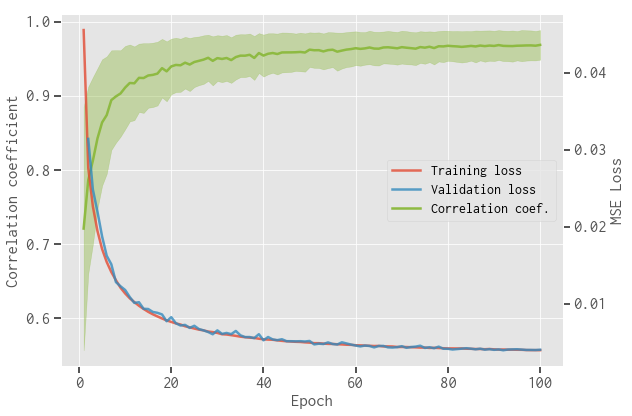

In [45]:
fig, axes = plot_modelfit(model, cb_index, figsize=(9, 6))

if False:
    fn = 'cdae-train.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

In [ ]:
now = datetime.now().strftime('%Y%m%dT%H%M')
modelfile = f'eor-detection-cdae.{now}.hdf5'

model.save(modelfile)
print(f'Saved model to file: {path.abspath(modelfile)}')

In [ ]:
modelfile = 'eor-detection-cdae.???.hdf5'
model = keras.models.load_model(modelfile)

### 5.4. Results

In [46]:
x_test_pred = model.predict(x_test)
cc_test = corrcoef_ds(x_test_pred[:, :, 0], x_test_label[:, :, 0])
a_summary(cc_test)

min: 0.5866621732711792
max: 0.9953725337982178
mean: 0.9687623403943432
std: 0.020083887018636046
median: 0.9737624824047089


In [48]:
tpix = np.random.randint(0, n_test, size=1)[0]
tpix

11103

corrcoef(tpred, tlabel): 0.9738020896911621
corrcoef(spred, slabel): 0.973791344005763


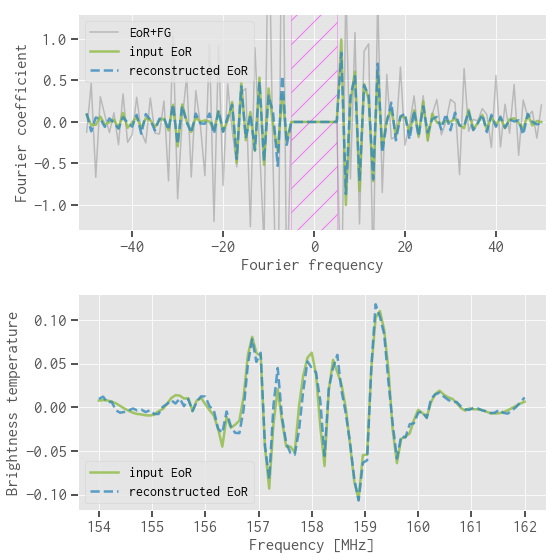

In [49]:
fig, axes = plot_modelresult(tpix, x_test, x_test_label, x_test_pred)

if False:
    fn = 'eor-result.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

In [50]:
zde_test_label = rfft_decode2(x_test_label[:, :, 0], nex=nex)
zde_test_pred  = rfft_decode2(x_test_pred[ :, :, 0], nex=nex)

nk = zde_test_label.shape[1]
k = np.arange(nk)

ps1_label = k[np.newaxis, :] * np.abs(zde_test_label)**2
ps1_pred  = k[np.newaxis, :] * np.abs(zde_test_pred)**2

p1_label = np.sum(ps1_label, axis=1)
p1_pred  = np.sum(ps1_pred,  axis=1)

pr = p1_pred / p1_label
a_summary(pr)

min: 0.5254986893109029
max: 1.4566274115312539
mean: 0.9012177279282979
std: 0.08912942491600984
median: 0.8995340565481891


---
---

## 6. Comparison: Without FT

In [51]:
x_data  = np.swapaxes(np.array(cube_tot.reshape((nfreq0, npix))), 0, 1)
x_label = np.swapaxes(np.array(cube_eor.reshape((nfreq0, npix))), 0, 1)

x_data  -= np.mean(x_data,  axis=1, keepdims=True)
x_label -= np.mean(x_label, axis=1, keepdims=True)

_std = np.std(x_data)
print(f'std(x_data): {_std}')
x_data /= _std

_max = np.max(np.abs(x_label))
print(f'max(abs(x_label)): {_max}')
x_label /= _max

std(x_data): 0.3753691613674164
max(abs(x_label)): 0.008441469632089138


In [52]:
np.random.seed(42)

idx = np.arange(npix)
np.random.shuffle(idx)

In [53]:
frac_validate, frac_test = 0.2, 0.2
n_validate = int(npix * frac_validate)
n_test = int(npix * frac_test)
n_train = npix - n_validate - n_test
print(f'n_train={n_train}, n_validate={n_validate}, n_test={n_test}')
    
idx_validate = idx[:n_validate]
idx_test = idx[n_validate:n_validate+n_test]
idx_train = idx[-n_train:]
    
x_train = x_data[idx_train, :, np.newaxis]
x_train_label = x_label[idx_train, :, np.newaxis]

x_validate = x_data[idx_validate, :, np.newaxis]
x_validate_label = x_label[idx_validate, :, np.newaxis]

x_test = x_data[idx_test, :, np.newaxis]
x_test_label = x_label[idx_test, :, np.newaxis]

n_train=77760, n_validate=25920, n_test=25920


In [56]:
del model
K.clear_session()

In [57]:
model = Sequential()

model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method,
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())

model.add(Conv1D( 1, 3, activation='tanh', padding=padding))

In [ ]:
cb_index = EvalIndexCallback(func=corrcoef, test_data=(x_test, x_test_label))
model.compile(optimizer=optimizer, loss=loss)
model.fit(x_train, x_train_label,
          epochs=epochs, batch_size=batch_size,
          validation_data=(x_validate, x_validate_label),
          callbacks=[cb_index],
          verbose=0)

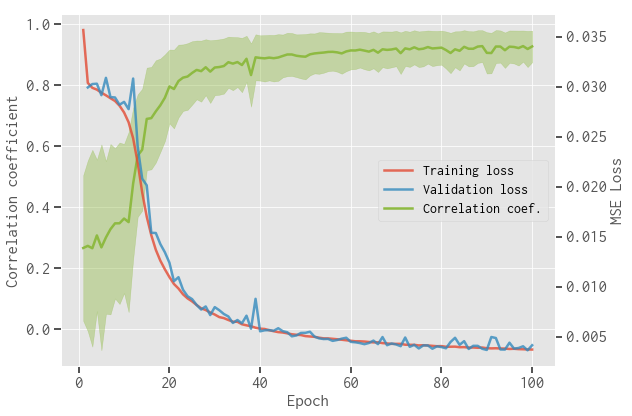

In [59]:
fig, axes = plot_modelfit(model, cb_index, figsize=(9, 6))

if False:
    fn = 'cdae-train-noft.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

In [60]:
x_test_pred = model.predict(x_test)
cc_test = corrcoef_ds(x_test_pred[:, :, 0], x_test_label[:, :, 0])
a_summary(cc_test)

min: 0.42873021960258484
max: 0.9954120516777039
mean: 0.9277416353872805
std: 0.050626899373528815
median: 0.94072625041008
